In [ ]:
!pip install dgl
!pip install torch
!pip install numpy
!pip install networkx
!pip install matplotlib
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import dgl
import torch 
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
import networkx as nx
import numpy as np
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader 
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import pandas as pd

train_data: 6826


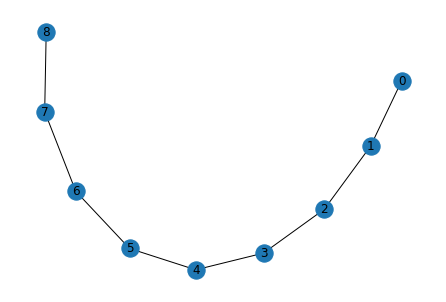

In [ ]:
n_labels = 5500  # one-hot_len txtの値の最大値以上に設定する


####  Scene Graph (train)  ############################################
train_data = np.loadtxt(fname="/content/drive/MyDrive/GCN/train80.txt",  dtype="int",  delimiter=" ")

trainset =[]

for data in train_data:
  label = data[9]                            # ground truth
  target_vector = [data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8]]   # feature ( size : 3 )
  feature_list = np.eye(n_labels)[target_vector]           # one hot表現に変換
  #print(label)
  g = dgl.graph(([0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8], [1,0,2,1,3,2,4,3,5,4,6,5,7,6,8,7]))      # edge
  g.ndata['feat'] = torch.from_numpy(np.array( feature_list).astype(np.float32)).clone() 
  trainset.append([g,label])
  

print("train_data:",len(trainset))
nx.draw(g.to_networkx().to_undirected(), with_labels=True)
plt.show()

######################################################################

1
12
9
18
7
17
19
24
12
21
12
10
10
2
24
18
7
10
22
3
20
13
3
1
20
7
2
20
24
14
16
6
10
23
3
7
17
13
22
13
23
18
16
18
24
1
21
14
6
2
test_data: 50


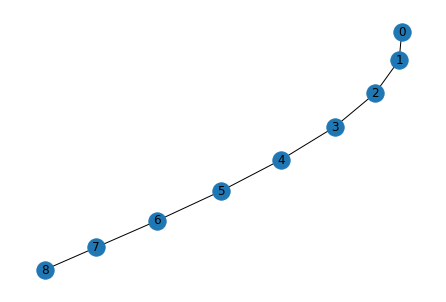

In [ ]:
####   Scene Graph (test)  ##############################################
test_data = np.loadtxt(fname="/content/drive/MyDrive/GCN/mirror.txt",  dtype="int",  delimiter=" ")

testset =[]

for data in test_data:
  label = data[9]                           # ground truth
  target_vector = [data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8]]   # feature ( size : 3 )
  feature_list = np.eye(n_labels)[target_vector]           # one hot表現に変換
  print(label)
  g = dgl.graph(([0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8], [1,0,2,1,3,2,4,3,5,4,6,5,7,6,8,7]))      # edge
 
  g.ndata['feat'] = torch.from_numpy(np.array( feature_list).astype(np.float32)).clone()  # node feature (node size : 3 )
  testset.append([g,label])

print("test_data:",len(testset))
nx.draw(g.to_networkx().to_undirected(), with_labels=True)
plt.show()
#####################################################################



In [ ]:
####   GCN   ########################################################

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

msg = fn.copy_src(src='h', out='m')
def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    
    accum = torch.sum(nodes.mailbox['m'], 1)
    #print(accum)
    return {'h': accum}


class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)
    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.ndata['feat']
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


###########################################################################


In [ ]:
####  train  ###############################

data_loader = DataLoader(
    trainset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=collate)


classes = 5500

# Create model
model = Classifier(5500, 256, classes)     
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001) 
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    if epoch_loss<0.05:
      break
    epoch_losses.append(epoch_loss)

##############################################



Epoch 0, loss 3.5209
Epoch 1, loss 2.9499
Epoch 2, loss 2.4467
Epoch 3, loss 1.7528
Epoch 4, loss 1.1458
Epoch 5, loss 0.7025
Epoch 6, loss 0.4154
Epoch 7, loss 0.2307
Epoch 8, loss 0.1252
Epoch 9, loss 0.0610
Epoch 10, loss 0.0338


In [ ]:
####  test ###################################

model.eval()
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

f=open('/content/drive/MyDrive/GCN/result_mirror_.txt','w')
for arg in argmax_Y:
  f.write(str(arg))
  f.write('\n')
f.close()

print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))  


################################################




Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%
